## Installation

In this notebook, we will have an overview of the Dask usage for both parallel and distributed computing.\
In the next cell, we also install all the packages for the various steps

Be sure to use **python3 and pip3 according to your system configuration**

In [1]:

!pip3 install scikit-learn spacy pandas numpy dask["complete"] graphviz nltk pyarrow
!python3 -m spacy download en_core_web_sm

zsh:1: no matches found: dask[complete]
     |████████████████████████████████| 13.7 MB 345 kB/s eta 0:00:01
You should consider upgrading via the '/Users/yonzhn/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import nltk
nltk.download('punkt')

To use and visualize the computational graphs we need also to install the package Graphviz.

To do this follows the below instructions.

+ OSX-USERS: type ```brew install graphviz``` in your console
+ UBUNTU-USERS: type ```sudo apt-get install graphviz``` in your console
+ WINDOWS/OTHERS: install the package directly from this [URL](https://graphviz.org/download/)

*Please note that this package is not mandatory, but without it you will not be able to visualize the graphs*.

## First step
Before starting with parallel and distributed computing let's write two simple functions, ```increment``` and ```add```, that contain a ```sleep``` to simulate intensive work.\
Then run these functions normally to see how long they take to execute.

In [1]:
from time import sleep


def increment(x):
    """
    takes a number x and return x+1
    sleep for 1s
    """
    sleep(1)
    return x + 1

def add(x, y):
    """
    sum y to x and return the result
    sleep for 1s
    """
    sleep(1)
    return x + y

In [2]:
%%time

x = increment(1)
y = increment(2)
z = add(x, y)

CPU times: user 708 µs, sys: 1.37 ms, total: 2.08 ms
Wall time: 3.02 s


This takes 3 seconds to run because we call each function sequentially. 

This means that the x value is computed as first, y as second, and z as third. *Each instruction is executed after the previous one*.

## Basic parallel computing
In this step, we parallelize the execution of the ```increment``` function. This operation is performed by wrapping the invocation of the function with the ```dask.delayed``` method. 

This wiill only prepare the parellel execution of the code without executing it.

The invocation returns the delayed object, which is a placeholder of the original computation. 

In [3]:

%%time

# the delayed function takes several arguments. the first argument is the function that has to be executed in parallel.
# the following arguments are the arguments of the original function.
from dask import delayed

x = delayed(increment)(1)
y = delayed(increment)(2)
z = delayed(add)(x, y)

CPU times: user 116 ms, sys: 53.4 ms, total: 169 ms
Wall time: 214 ms


In [4]:
z

Delayed('add-f50c0266-fe66-441f-a680-44e7eaeffa54')


With ```z.compute()``` instruction we are triggering the execution of our source code.

In [5]:
%%time

z.compute() 

CPU times: user 8.43 ms, sys: 11.4 ms, total: 19.9 ms
Wall time: 2.03 s


5

As we can see, the total execution time of parallelized code is **2s** while the execution time of the non-parallelized code was **3s**.

The parallelized version was 1 second faster because some instructions have been executed concurrently.

With the following ```visualize``` command will generate and show the computational graph to understand what is happened.

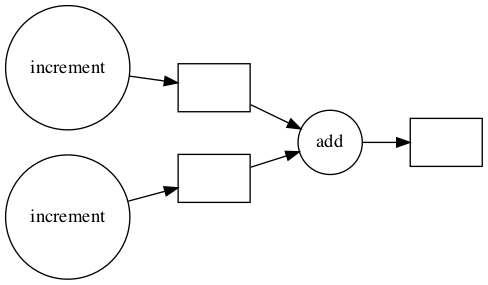

In [10]:
# do not run this cell if you have not installed the graphviz package
z.visualize(rankdir="LR", filename='increment-basic-example-graph.png')


As depicted by the graph, the two increment calls have been executed in parallel so this has allowed us to be faster than the sequential code.

Let's see another example. 

In this example, we read some data from one source (an array), increment each element, and then put the results on a new output source (array).\
Finally, we sum all the new numbers.

In [11]:
def increment(x):
    sleep(1) #remember, this is used to simulate an intesive work
    return x + 1

data = [1, 2, 3, 4, 5, 6, 7, 8]

In the folliwing we show the sequential approach to solve our problem

In [12]:
%%time

# Sequential code
results = []
for x in data:
    y = increment(x)
    results.append(y)
    
result = sum(results)
print("After computing : {}".format(result))

After computing : 44
CPU times: user 1.26 ms, sys: 1.9 ms, total: 3.16 ms
Wall time: 8.03 s


Now run the cell below and see what happens

In [13]:
%%time

results = []
for x in data:
    y =  delayed(increment)(x)
    results.append(y)
    
total =  delayed(sum)(results) 
result = total.compute()

print("After computing : {}".format(result))

After computing : 44
CPU times: user 3.83 ms, sys: 4.61 ms, total: 8.43 ms
Wall time: 1.01 s


We reduced the computational time by a factor of ~8

## Basic distributed computing

In the previous part we observed how to perform some basic operations with parallel computing.\
But what about the distributed part?\
As the first step, we create a cluster and we connect to it.

**Warning**: the number of workers should fit your resources. E.g.: if you are using your laptop with 8 cores, the `WORKERS_NUMBER`paramter should be <= 8.

In [16]:
from dask.distributed import Client, LocalCluster

WORKERS_NUMBER = 2
cluster = LocalCluster(name="basicCluster", n_workers=WORKERS_NUMBER)
client = Client(cluster)

client

/Users/yonzhn/opt/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50819 instead
  warnings.warn(
distributed.nanny - ERROR - Failed while trying to start worker process: Unexpected response from register: {'status': 'error', 'message': 'name taken, basicCluster', 'time': 1635488149.965121}
Task exception was never retrieved
future: <Task finished name='Task-96' coro=<_wrap_awaitable() done, defined at /Users/yonzhn/opt/anaconda3/lib/python3.8/asyncio/tasks.py:677> exception=ValueError("Unexpected response from register: {'status': 'error', 'message': 'name taken, basicCluster', 'time': 1635488149.965121}")>
Traceback (most recent call last):
  File "/Users/yonzhn/opt/anaconda3/lib/python3.8/asyncio/tasks.py", line 684, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/Users/yonzhn/opt/anaconda3/lib/python3.8/site-packages/distribut

ValueError: Unexpected response from register: {'status': 'error', 'message': 'name taken, basicCluster', 'time': 1635488150.584384}

After we create the connection to the cluster, we can try to submit different tasks.\
In the following cell we increment a number by using the previous `increment` function using the cluster resources.

To this end, we use the `submit` method to send the task to the cluster

In [ ]:
features = client.submit(increment, 1)

Let's try to see the result of the computation

In [ ]:
features

The ```features``` object does not contain the result of the invocation of the method `increment` over the number 1, but it contains the ```promise``` of the execution of this task.\
As seen before, Dask is lazy, so ```features``` contains the `id` of the task we submit to the cluster. We can use this ```id``` to retrieve the result. 

In [ ]:
real_result = client.gather(features)
real_result

To do this, we used the `gather` method. This method takes as input a promise of execution and retrieves the result from the cluster.

Can we execute an operation over a list of inputs?\
The method `map`, exactly to this: given a list of input, independently from the type of those inputs, it applies the passed function in parallel to each item in the list

In [ ]:
data = [1,2,3,4,5,6,8,9]
features = client.map(increment, data)

But what does the `features` object contain now?

In [ ]:
features

It contains a list of promises, one for each element in the input data.
Not let's retrieve the results with the `gather` method

In [ ]:
real_result = client.gather(features)

In [ ]:
real_result

We concluded our task so we can close the cluster.

In [ ]:
client.close() # close the connection to the cluster
cluster.close() # kill the cluster

## Example: entities extraction from corpus

Now we learned how to parallelize and distribute some trivial tasks. 
In this section we will show a more complex example.

Specifically, our goal is to extract named entities contained in a corpus.\
To this end, we will use an entity extractor model from Spacy and a common dataset from Sklearn.

At first, let's download a subset of the news dataset from the sklearn library

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import time

categories = [
     'sci.space'
]

dataset = fetch_20newsgroups(subset='train', categories=categories ).data

print("Number of documents in the corpus: "+str(len(dataset)))

Now let's create the cluster as in the previous step!

In [ ]:
from dask.distributed import Client, LocalCluster

WORKERS_NUMBER = 4

In [ ]:
cluster = LocalCluster(n_workers=WORKERS_NUMBER, dashboard_address='0.0.0.0:8787')
client = Client(cluster)

The next step is to extract all the entities contained in the corpus. 
To do this, we use the `en_core_web_sm` model from the Spacy library. The model has been downloaded during the installation step

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def get_entities(text):
    """
    This function takes a text as input and returns the entities contained into the text
    """
    
    return [str(ent) for ent in nlp(text).ents]

Let's create, run, and monitorate the sequential code

In [ ]:
%%time

total_entities = []
for index in range(0, len(dataset)):
    total_entities = total_entities + get_entities(dataset[index])
    if index % 100 == 0:
        print(f'Done: {index}/{len(dataset)}')
print()        

The sequential version is pretty slow, can we speed up the computation with Dask?
At first, we have to rewrite the ```get_entites``` function to load the model inside it.

In [ ]:
import spacy
def get_entities_for_distributed(text):
    nlp = spacy.load('en_core_web_sm')
    """
    This function takes a text as input and returns the entities contained into the text
    """
    return [str(ent) for ent in nlp(text).ents]

The parallel version becomes:

In [ ]:
%%time

futures = client.map(get_entities_for_distributed, dataset)

total_entities = []

for partial_entities in client.gather(futures):
    total_entities += partial_entities

As you can see, we are not getting a speed up. The main problem is that each worker loads the model multiple times, creating a lot of overhead.

What can we do?

Let's try to engineer a little the code:
+ divide the dataset into batches
+ parallelize over the batches
+ extract the entities in a sequential way for each bactch

In [ ]:
def get_entities_for_distributed(document_batch):
    nlp = spacy.load('en_core_web_sm')
    """
    This function takes a batch of document as input and returns the entities contained into these documents
    """
    entities = []
    for text in document_batch:
        entities + list(map(str,nlp(text).ents))
    return entities

In [ ]:
batch_size = 30
dataset_batches = [dataset[i:i + batch_size] for i in range(0, len(dataset), batch_size)]

In [ ]:
len(dataset_batches)

We have 20 batches each one containing ~30 documents

In [ ]:
%%time
import numpy as np

futures = client.map(##complete this function)

total_entities = []

for partial_entities in client.gather(futures):
    total_entities += partial_entities

As we can see, the distributed version took less time also with a good improvement: **IT WORKS**

We can close the connections and we can move to the final hands-on.

In [ ]:
client.close()
cluster.close()